# Calculate correlations between two datasets - Luthando

**Input file**: .csv table contains samples in columns and features in rows. First column is sample name.

**Parameters**:

In [1]:
input_file <- "count_table_Luthando.csv"
rows_ds1 <- 1:12498 # which rows (not including header) contain dataset1?
rows_ds2 <- 12499:13824 # which rows (not including header) contain dataset2?
prev_filt <- 0.1 # minimum % of samples that a feature must be observed in
norm_ds1 <- TRUE # do you want to normalize the first dataset?
norm_ds2 <- FALSE # do you want to normalize the second dataset?
scale_features <- TRUE # do you want to scale prior to correlation?
padj_meth <- "bonferroni" # method to adjust for multiple hypothesis tests (can change to "BH" to be less stringent)
p_thresh <- 0.05 # alpha for adjusted pvalues

## Load libraries

In [2]:
install.packages("Hmisc")

Warning message in install.packages("Hmisc"):
“installation of package ‘Hmisc’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [3]:
install.packages("corrplot")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [4]:
install.packages('d3heatmap')

Warning message:
“package ‘d3heatmap’ is not available (for R version 3.6.1)”

In [5]:
install.packages("devtools")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [9]:
if (!require("devtools")) install.packages("devtools")
devtools::install_github("rstudio/d3heatmap", force = TRUE)

stringi (1.4.3 -> 1.8.3) [CRAN]
stringr (1.4.0 -> 1.5.1) [CRAN]


Installing 2 packages: stringi, stringr
Warning message in i.p(...):
“installation of package ‘stringi’ had non-zero exit status”Warning message in i.p(...):
“installation of package ‘stringr’ had non-zero exit status”Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


── R CMD build ─────────────────────────────────────────────────────────────────
* checking for file ‘/private/var/folders/mk/s89dd3_s1g3df6ctgmxs75r80000gn/T/RtmpZBysX2/remotes81374bb2e90a/talgalili-d3heatmap-c8a3c64/DESCRIPTION’ ... OK
* preparing ‘d3heatmap’:
* checking DESCRIPTION meta-information ... OK
* checking for LF line-endings in source and make files and shell scripts
* checking for empty or unneeded directories
* building ‘d3heatmap_0.9.0.tar.gz’



In [10]:
library(d3heatmap)
library(Hmisc)
library(pheatmap)
library(reshape2)
library(RColorBrewer)


Welcome to d3heatmap version 0.9.0

Type citation('d3heatmap') for how to cite the package.
Type ?d3heatmap for the main documentation.

The github page is: https://github.com/talgalili/d3heatmap/
Please submit your suggestions and bug-reports at: https://github.com/talgalili/d3heatmap/issues
You may ask questions at stackoverflow, use the r and d3heatmap tags: 
	 https://stackoverflow.com/questions/tagged/d3heatmap


Attaching package: ‘d3heatmap’

The following objects are masked from ‘package:base’:

    print, save

Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:base’:

    format.pval, units



ERROR: Error in value[[3L]](cond): Package ‘htmlwidgets’ version 1.5.3 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘htmlwidgets’ is imported by ‘d3heatmap’, ‘profvis’, ‘htmlTable’ so cannot be unloaded



In [36]:
library(pheatmap)

In [45]:
library(RColorBrewer)

In [49]:
install.packages("htmlwidgets")

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [51]:
library(htmlwidgets)

ERROR: Error in value[[3L]](cond): Package ‘htmlwidgets’ version 1.5.3 cannot be unloaded:
 Error in unloadNamespace(package) : namespace ‘htmlwidgets’ is imported by ‘profvis’, ‘d3heatmap’, ‘htmlTable’ so cannot be unloaded



## Read in data

In [11]:
data <- read.csv('correlation-table-metabolotes-and-microbes.csv')

Check that the row numbers provided are correct

In [12]:
if (nrow(data) == length(c(rows_ds1, rows_ds2))) {message("Looks good!")} else message("Check row numbers again")

Looks good!


## Format data

In [13]:
datat <- t(data) # transpose so that samples are in rows and features are in columns
colnames(datat)<- datat[1,] # feature names are now the first row, make this row the column names
datat <- datat[-1,] # then remove it
datat <- as.data.frame(datat,stringsAsFactors=F)
datat <- as.data.frame(sapply(datat, as.numeric)) # make all values numeric
rownames(datat) <- colnames(data)[-1] # use sample names as row names

## Separate the two datasets for filtering/normalization

In [14]:
ds1 <- datat[,rows_ds1]
ds2 <- datat[,rows_ds2]

## Prevalence filter

Since there are so many features, we can reduce the number based on how many samples have the feature. For example, if the cutoff is 10%, we only keep features observed in at least 10% of samples

In [15]:
ds1_filt <- ds1[,apply(ds1, 2, function(x) {sum(x > 0) > prev_filt*nrow(ds1)})]
ds2_filt <- ds2[,apply(ds2, 2, function(x) {sum(x > 0) > prev_filt*nrow(ds2)})]

## Normalize data by total sum scaling

In the original code, they added 1 to every feature but I'm not sure why?

In [16]:
if (norm_ds1) {
  ds1_norm <- t(apply(ds1_filt, 1, function(x) {x/sum(x)})) # for each sample (row) divide each feature by the sum of all features
} else ds1_norm <- ds1_filt

if (norm_ds2) {
  ds2_norm <- t(apply(ds2_filt, 1, function(x) {x/sum(x)})) 
} else ds2_norm <- ds2_filt

## Scale data

In [17]:
if (scale_features) {
  ds1_norm <- scale(ds1_norm)
  ds2_norm <- scale(ds2_norm)
}

## Calculate correlations between ds1 (x) and ds2 (y)

In [18]:
cor_mat <- Hmisc::rcorr(x = as(ds1_norm, "matrix"), y = as(ds2_norm, "matrix"), type = "spearman") # spearman recommended for microbiome data

# get correlations
cor_r <- cor_mat$r[1:ncol(ds1_norm), -c(1:ncol(ds1_norm))] # removing ds1~ds1 and ds2~ds2 correlations, so we only keep ds1~ds2 correlations
# get pvalues
cor_p <- cor_mat$P[1:ncol(ds1_norm), -c(1:ncol(ds1_norm))]

In [19]:
head(cor_r)
head(cor_p)

,4,880,2198,27,28,5,7,2363,49,254,...,1012,2024,11135,6603,15498,9608,932,5186,10315,823
otu1,-0.5356732,-0.01037816,0.02868335,0.003219058,0.035395158,-0.33271644,-0.4335985,0.02693218,0.10076193,-0.10070149,...,-0.2473697,-0.37542074,-0.10145908,0.03908713,-0.14931738,-0.16897739,-0.3100802,-0.07267444,-0.09000281,-0.2099107
otu2,-0.1406552,0.37540059,0.37072580,-0.098744196,0.004965540,-0.03071643,-0.1319483,0.38878209,-0.36614979,-0.09011957,...,-0.1108467,-0.05660550,0.10538415,-0.07031278,0.01558691,-0.23388217,-0.2342669,-0.08699772,-0.11861631,0.2446781
otu3,0.4452875,-0.11345851,-0.13928093,-0.084727958,-0.199878274,0.42072850,0.4284049,-0.13007368,0.22559229,-0.09520589,...,0.1313637,0.23282781,-0.15853148,-0.22859427,-0.10741110,-0.08290114,0.3930917,-0.25725502,-0.17760257,0.1273792
otu4,-0.2616893,0.19554730,0.18028565,-0.052573443,-0.004305487,-0.07726866,-0.2025936,0.21076941,-0.09322276,-0.05558261,...,-0.1503024,-0.08485505,0.05611578,-0.05567953,0.03301835,-0.28033829,-0.2624764,-0.10971826,-0.25382258,0.1431418
otu5,0.3096594,0.04762462,0.05249167,0.096175001,-0.036887426,0.27111882,0.3859864,0.04996912,-0.10178343,0.19845456,...,0.2465520,0.25264212,0.13688553,0.22158266,0.19633248,0.37943761,0.2924864,0.07486702,0.34350458,0.1255736
otu6,-0.3511984,0.03125327,0.06727812,-0.128675579,0.038461449,-0.34027374,-0.4402230,0.05951486,-0.04502685,-0.04499033,...,-0.2001739,-0.42567499,-0.17834037,-0.05831405,-0.09991162,-0.08699266,-0.3546300,0.02575924,0.04885874,-0.2471561


,4,880,2198,27,28,5,7,2363,49,254,...,1012,2024,11135,6603,15498,9608,932,5186,10315,823
otu1,1.639157e-09,9.143078e-01,7.661167e-01,0.9733746,0.7135430,3.831333e-04,2.224754e-06,7.800215e-01,2.949169e-01,0.29520816,...,0.009176117,5.315153e-05,0.29157154,0.68516795,0.11949283,7.761120e-02,9.784619e-04,0.450544703,0.3497503274,0.027736361
otu2,1.427440e-01,5.320467e-05,6.696521e-05,0.3047417,0.9589395,7.500665e-01,1.694130e-01,2.700453e-05,8.359279e-05,0.34912303,...,0.248973456,5.569534e-01,0.27320724,0.46543512,0.87160572,1.392610e-02,1.376549e-02,0.366137790,0.2171249117,0.009990056
otu3,1.091565e-06,2.379268e-01,1.467278e-01,0.3788231,0.0362984,4.728233e-06,3.027102e-06,1.756082e-01,1.780561e-02,0.32248180,...,0.171327218,1.437465e-02,0.09809159,0.01630459,0.26403586,3.892240e-01,2.156916e-05,0.006665422,0.0634224204,0.184802733
otu4,5.752522e-03,4.062881e-02,5.946683e-02,0.5854279,0.9643937,4.223543e-01,3.378650e-02,2.709080e-02,3.327094e-01,0.56411373,...,0.117045944,3.781058e-01,0.56037596,0.56343337,0.73202222,3.013600e-03,5.602653e-03,0.253854088,0.0074579735,0.135744467
otu5,9.949877e-04,6.212597e-01,5.860122e-01,0.3175582,0.7020243,4.171432e-03,3.119091e-05,6.041668e-01,2.900237e-01,0.03767699,...,0.009416965,7.749194e-03,0.15387151,0.01999567,0.03981315,4.349551e-05,1.930756e-03,0.436961831,0.0002387812,0.191157576
otu6,1.686366e-04,7.458459e-01,4.849583e-01,0.1803361,0.6899472,2.756011e-04,1.490886e-06,5.368295e-01,6.404370e-01,0.64070828,...,0.036017555,3.551782e-06,0.06231391,0.54509160,0.29903148,3.661657e-01,1.439874e-04,0.789374254,0.6122363217,0.009238502


## Heatmap

In [34]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
 
# install and load package
BiocManager::install("DESeq2")
library("DESeq2")

Bioconductor version 3.10 (BiocManager 1.30.10), R 3.6.1 (2019-07-05)
Installing package(s) 'DESeq2'
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Old packages: 'BH', 'BiocManager', 'DBI', 'DT', 'Formula', 'Hmisc',
  'IRdisplay', 'IRkernel', 'KernSmooth', 'Matrix', 'ModelMetrics', 'RCurl',
  'RSQLite', 'SQUAREM', 'TTR', 'askpass', 'backports', 'bit', 'bitops', 'blob',
  'boot', 'brew', 'broom', 'caret', 'checkmate', 'class', 'clipr', 'cluster',
  'codetools', 'covr', 'credentials', 'crosstalk', 'data.table', 'dbplyr',
  'dichromat', 'dplyr', 'forcats', 'foreach', 'formatR', 'generics',
  'gitcreds', 'glmnet', 'gower', 'haven', 'hexbin', 'hms', 'httr', 'ipred',
  'iterators', 'jpeg', 'latticeExtra', 'lava', 'lubridate', 'maps', 'markdown',
  'mgcv', 'modelr', 'nlme', 'nnet', 'numDeriv', 'pbdZMQ', 'plyr',
  'prettyunits', 'prodlim', 'progress', 'purrr', 'quantmod', 'readr', 'readxl',
  'recipes', 'rematch', 'repr', 'reprex', 'rex', 'rpart', 'rprojroot',
  

In [37]:
pheatmap(t(cor_r),  clustering_method="ward.D", clustering_distance_cols="canberra",
         show_colnames = TRUE,show_rownames = TRUE, cluster_rows = TRUE, cluster_cols = TRUE, fontsize = 1, 
         filename = "corr_coef_all.pdf")

## Interactive heatmap

(this file was too big to open on my laptop!)

In [46]:
map <- d3heatmap(t(cor_r), distfun=function(x) dist(x, method="canberra"), 
                 hclustfun=function(x) hclust(x, method="ward.D"),
                 color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(100))
saveWidget(map, "corr_coef_all.html")

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
”Warning message:
“Some values were outside the color scale and will be treated as NA”Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
”

ERROR: Error in saveWidget(map, "corr_coef_all.html"): could not find function "saveWidget"


## Remove correlations with padj < alpha

In [39]:
install.packages("reshape")
library(reshape)
install.packages("reshape2")
library(reshape2)

Updating HTML index of packages in '.Library'
Making 'packages.html' ... done
Updating HTML index of packages in '.Library'
Making 'packages.html' ... done


In [40]:
hold_r <- melt(cor_r) # putting all values in one column
hold_p <- melt(cor_p)
hold_p$padj <- p.adjust(hold_p$value, method = padj_meth) # adjust pvals for multiple hypothesis tests

hold_r_sig <- hold_r[hold_p$padj < p_thresh,]
hold_p_sig <- hold_p[hold_p$padj < p_thresh,]

# new matrix with only significant correlations (insignificant correlations are set to 0)
corr_r_sig <- dcast(hold_r_sig, Var1~Var2, fill = 0)
row.names(corr_r_sig) <- corr_r_sig$Var1 # re-assign row names as feature names then remove that column
corr_r_sig <- corr_r_sig[,-1]

## Plot heatmap again

In [44]:
pheatmap(t(corr_r_sig),  clustering_method="ward.D", clustering_distance_cols="canberra",
         show_colnames = TRUE,show_rownames = TRUE, cluster_rows = TRUE, cluster_cols = TRUE, fontsize = 1, 
         filename = "corr_coef_sig.pdf")

In [52]:
map <- d3heatmap(t(corr_r_sig), distfun=function(x) dist(x, method="canberra"), 
                 hclustfun=function(x) hclust(x, method="ward.D"),
                 color = colorRampPalette(rev(brewer.pal(n = 7, name = "RdYlBu")))(100))
saveWidget(map, "corr_coef_sig.html") 

Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
”Warning message:
“Some values were outside the color scale and will be treated as NA”Warning message in RColorBrewer::brewer.pal(n, pal):
“n too large, allowed maximum for palette RdYlBu is 11
Returning the palette you asked for with that many colors
”

ERROR: Error in saveWidget(map, "corr_coef_sig.html"): could not find function "saveWidget"


## Save tables

In [42]:
colnames(hold_r)[3] <- "corr_coef" # fix column names
colnames(hold_p)[3] <- "pval"
to_save <- cbind(hold_r, hold_p[,3:4]) # join coefs and pvals
write.csv(to_save, "corr_coef_all.csv", row.names = FALSE) # save table

# save only correlations with significant pval
write.csv(subset(to_save, to_save$pval < p_thresh), "corr_coef_sig.csv", row.names = FALSE) 

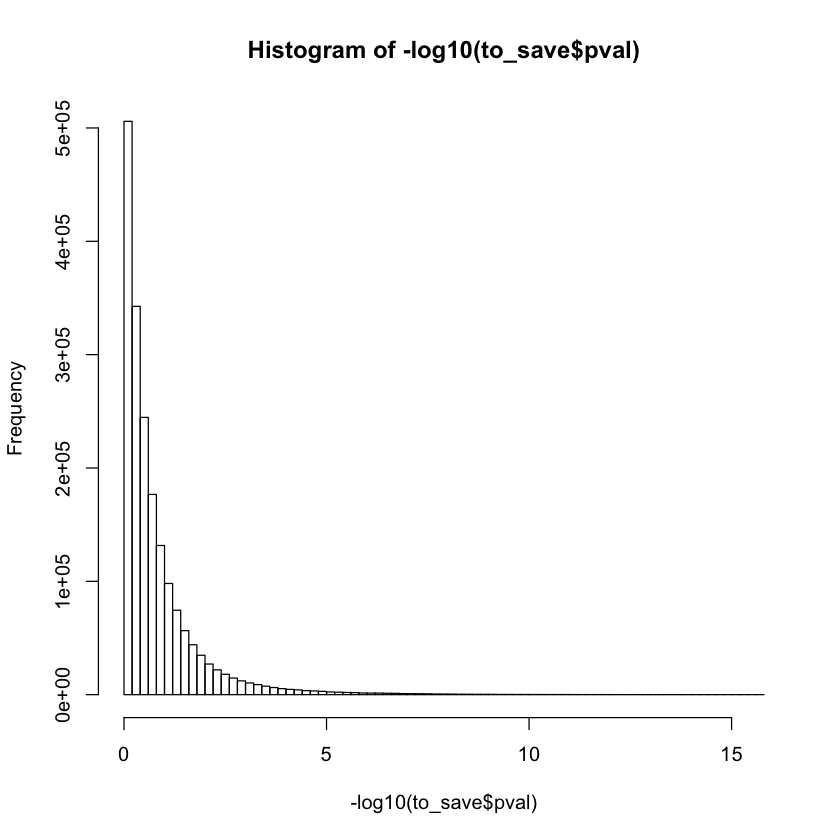

In [27]:
hist(-log10(to_save$pval),breaks=100)

quartz_off_screen 
                3

pdf 
  2

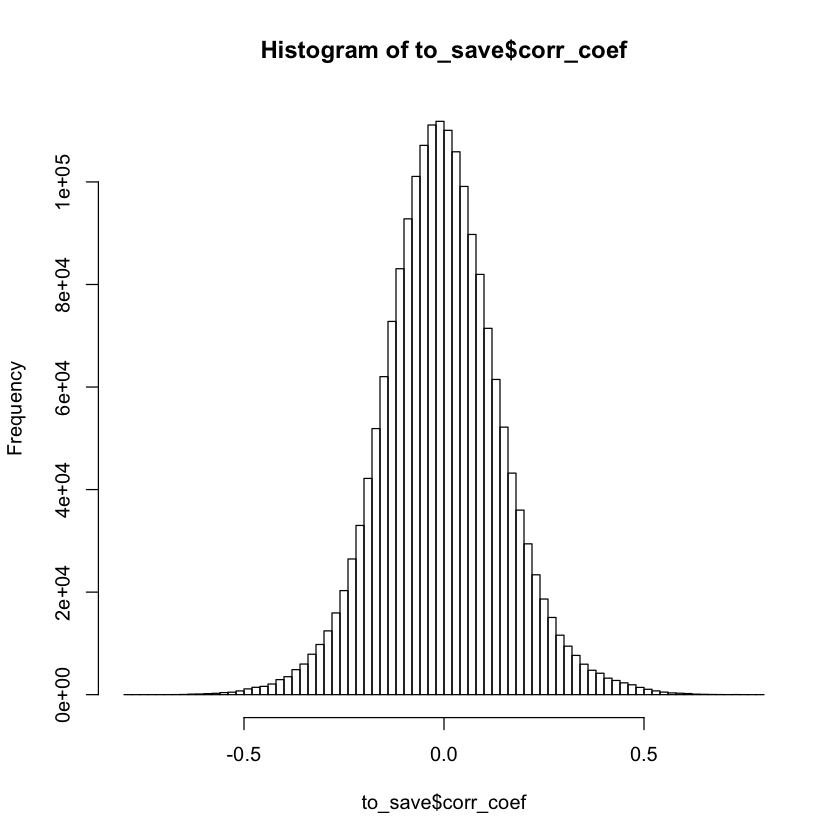

In [28]:
hist(to_save$corr_coef,breaks=100)
dev.copy(png,'histogram_sig.png')
dev.off()

Warning message in if (freq) x$counts else x$density:
“the condition has length > 1 and only the first element will be used”Warning message in if (!freq) "Density" else "Frequency":
“the condition has length > 1 and only the first element will be used”

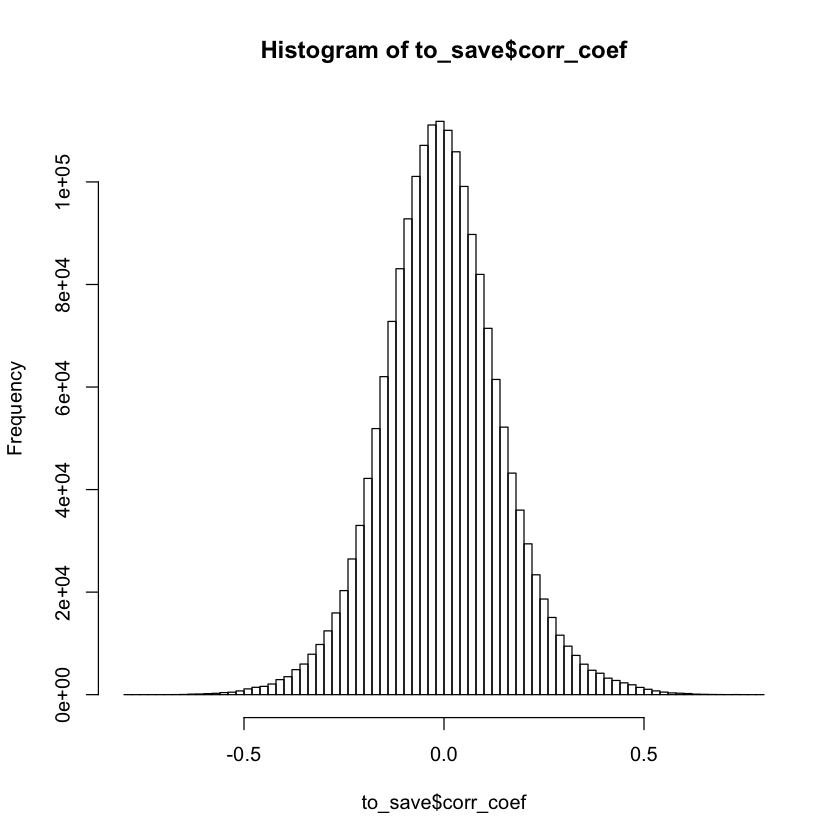

In [29]:
hist(to_save$corr_coef,-1:1, breaks=100)

Warning message in if (freq) x$counts else x$density:
“the condition has length > 1 and only the first element will be used”Warning message in if (!freq) "Density" else "Frequency":
“the condition has length > 1 and only the first element will be used”

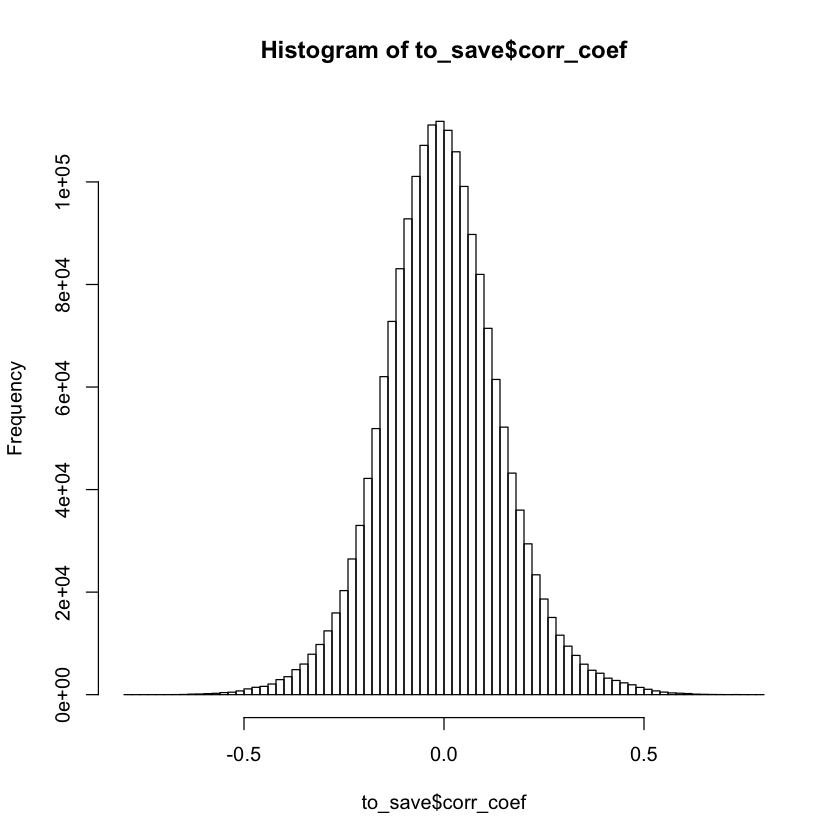

In [30]:
h_1 <- hist(to_save$corr_coef,-1:1, breaks=100)

In [31]:
h_1$breaks

[1] -0.80 -0.78 -0.76 -0.74 -0.72 -0.70 -0.68 -0.66 -0.64 -0.62 -0.60 -0.58
[13] -0.56 -0.54 -0.52 -0.50 -0.48 -0.46 -0.44 -0.42 -0.40 -0.38 -0.36 -0.34
[25] -0.32 -0.30 -0.28 -0.26 -0.24 -0.22 -0.20 -0.18 -0.16 -0.14 -0.12 -0.10
[37] -0.08 -0.06 -0.04 -0.02  0.00  0.02  0.04  0.06  0.08  0.10  0.12  0.14
[49]  0.16  0.18  0.20  0.22  0.24  0.26  0.28  0.30  0.32  0.34  0.36  0.38
[61]  0.40  0.42  0.44  0.46  0.48  0.50  0.52  0.54  0.56  0.58  0.60  0.62
[73]  0.64  0.66  0.68  0.70  0.72  0.74  0.76  0.78  0.80

In [32]:
h_1$counts

[1]      1      2      5      3      3      9     17     40    102    127
[11]    198    266    407    483    729   1126   1434   1618   2078   2932
[21]   3508   4880   5971   7886   9787  12440  15936  20295  26465  33004
[31]  42177  51894  62023  72794  83074  92797 101075 107132 111106 111819
[41] 110065 105879  99122  89756  81968  71448  61478  52176  43209  35994
[51]  29415  23378  18651  15057  11599   9459   7657   5944   4761   4178
[61]   3215   2769   2306   1926   1416   1051    734    501    345    279
[71]    217    102     67     38     23     10     22      9      0      1